Warning message:
"Removed 607 rows containing missing values (geom_text_repel)."
Saving 6.67 x 6.67 in image

Warning message:
"Removed 607 rows containing missing values (geom_text_repel)."


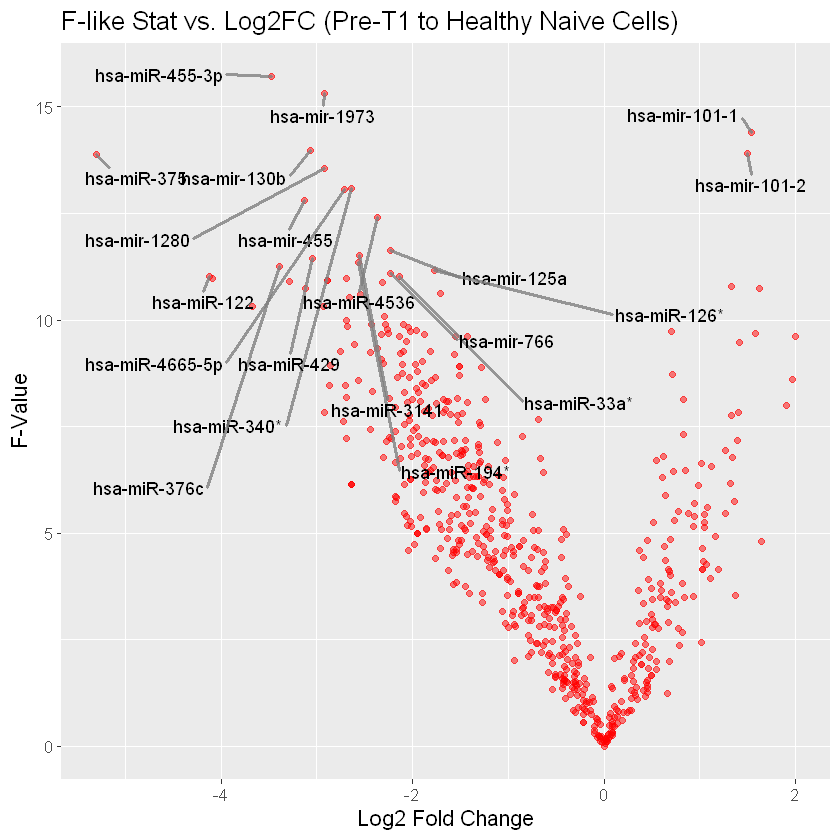

In [3]:
library(limma)
library(reshape2)
library(Glimma)
library(ggplot2)
library(ggrepel)
library(edgeR)
library(gplots)
library(amap)



# WORKING DIR input
setwd("C:\\Users\\Pete\\DSC180B-PROJECT")

# ingestion inputs
file_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE44639&format=file'            
raw_dir = "data/raw/"
temp_dir = "data/temp/"
file_name = 'GSE44639_RAW.tar'

# ingest data function
ingest_data <- function(file_url, file_name, raw_dir, temp_dir) {
    if (!dir.exists(raw_dir)) {
        dir.create(raw_dir, recursive = TRUE)
    }
    out = paste(raw_dir, file_name, sep="")
    utils::download.file(file_url, destfile=out, mode="wb")
    utils::untar(out, exdir=temp_dir)
}

ingest_data(file_url, file_name, raw_dir, temp_dir)


# transform ingested data into one concat df
read_all_files_in_dir_with_columns <- function(file_dir, required_columns) {
    files <- list.files(path=file_dir)
    
    all <- list()
    
    for (i in files) {
        fp <- paste(file_dir, i, sep='')
        seqdata <- read.delim(gzfile(fp), stringsAsFactors = FALSE)
        columns <- colnames(seqdata)
        
        has_unidentified_col <- FALSE
        
        # ignore samples with columns not present in required_columns
        for (c in columns) {
            if (!any(required_columns==c)) {
                has_unidentified_col <- TRUE
                break
            }
        }
        
        if (has_unidentified_col) {
            next
        }
        
        sampleName = strsplit(fp, "/")[[1]][3]
        sampleName = strsplit(sampleName, ".txt")[[1]][1]
        
        
        cellType = strsplit(fp, "_")[1]
        cellType = cellType[[1]][3]
        cellType = strsplit(cellType, ".txt")
        cellType = cellType[[1]][1]
        
        healthy <- !grepl("P", fp, fixed=TRUE)
        
        # add healthy column
        seqdata$healthy <- healthy
        seqdata$cellType <- cellType
        seqdata$sampleName <- sampleName
        
        if (length(all) == 0) {
            all <- seqdata
        } else {
            all <- rbind(all, seqdata)
        }
    }
    
    return(all)
}

required_columns <- list("miRNA", "Chromosome", "Position", "Strand", "Total.miRNA.reads", "RPM..reads.per.million.")
all <- read_all_files_in_dir_with_columns(temp_dir, required_columns)



# SELECT NAIVE CELLS GROUP ONLY
pret1 <- all[all$healthy == FALSE,] 
naive <- all[all$cellType == 'Naive',] 

# TRANSFORM THE CONCAT DATAFRAME INTO PIVOTED COUNTS TABLE (SAMPLE ~ MIRNA)
countdata <- dcast(naive, miRNA ~ sampleName, value.var= "Total.miRNA.reads", fill= 0)

rownames(countdata) <- countdata$miRNA
countdata$miRNA <- NULL
# countdata

# TO TRANSFORM THE COUNTS INTO LOG(RPM)

# add 0.5 to counts to prevent log(0) = -inf
countdata <- countdata + 0.5

group<-factor(c(rep("pret1Naive",6),rep("healthyNaive",7))) 
d <- DGEList(counts=countdata,group=group) # DGEList helps us transform/separate the dataframe into multiple with summary info (libsize etc).

# #filter, need counts over 1 in 6 samples NOTE: NOT USING
# keep <- rowSums(cpm(d)>1) >= 6
# d <- d[keep,]
# dim (d)

# d$samples
# FILTER all mirna with less than 1.5*(# of total samples) of counts across all samples. removes lowly expressing mirna
dd <- d[rowSums(d$counts) >= 1.5*ncol(d), ]
# multiply by million and divide by column library size to get RPM
d<-1e+06 * dd$count/expandAsMatrix(d$samples$lib.size,dim(dd))
# take the log RPM
d<-log2(d)
# d

# FILTER USING ABS(F) FUNCTION

# CALCULATE ABS-F FUNCTION. has hard coded values for group size. helps us choose from the top DE mirna, which to talk about
# GOT FROM AUTHOR
F<-data.frame(nrow(d))
x<-data.frame(nrow(d),2) # for calculating fold change later
for (i in 1:nrow(d)) {
a<-6*abs(mean(d[i,1:6])-mean(d[i,1:13]))+7*abs(mean(d[i,7:13])-mean(d[i,1:13]))
bb = 0
    for (j in 1:6) {
        b<-abs(d[i,j]-mean(d[i,1:6]))
        bb = bb +b
    }

    for (j in 7:13) {
        b<-abs(d[i,j]-mean(d[i,7:13]))
        bb = bb +b
    }

    F[i]<-12*a/bb

    # X contains the mean of the logRPM of each group.
    x[i,2]<-mean(d[i,1:6])
    x[i,1]<-mean(d[i,7:13])

}

names(F)<-rownames(d)
rownames(x)<-rownames(d)

absFOver9.6<-length(F[,F>9.6]) # 9.6 chosen from paper. corresponds to less than 1% false discovery rate in limma package
# absFOver9.6


#### VOLCANO PLOT 

# f contains the fold change, F contains the abs-F value

f <- x[names(-sort(-F))[1:absFOver9.6],1]-x[names(-sort(-F))[1:absFOver9.6],2] # fold change on the mirna with ABS F>9.6

names(f)<-names(-sort(-F))[1:absFOver9.6]
# -sort(-f)

# FILTER by abs(logFC) >= 1
id<-c(names(f[f>=1]),names(f[-f>=1]))
# length(id)

# calculate logFC again for mirna which meet filters, might be redundant
y<-d[id,]
de<-rownames(x)%in%id
f<-c(x[de,1]-x[de,2])

saved_mirna<- rownames(x[de,])
names(f)<- saved_mirna
# f gives us the filtered names of mirna with absF > 9.6 with abs(logFC) >=1. helps us choose which to talk about
#f 

# CREATE X AND Y VALUES FOR VOLCANO PLOT. X= LOGFC, Y= ABS(F). 
fval<-as.numeric(F)
fold<-as.numeric(x[,1]-x[,2])

volcanodf<-data.frame(fold,fval)


## 20 highest F-values labeled
numToLabel = 20

ggplot(volcanodf, aes(fold,fval)) +
    geom_point(color='red',alpha = 0.5) + 
    geom_text_repel(aes(fold,fval),segment.size = 1, min.segment.length=0.5, box.padding=1,
    segment.alpha = .8,
    force = 1,segment.color = "grey50",label=as.character(ifelse(F >= as.numeric(-sort(-F)[numToLabel]), colnames(F), NA)),hjust=0,vjust=0) +
    labs(y= "F-Value", x = "Log2 Fold Change") +
    ggtitle("F-like Stat vs. Log2FC (Pre-T1 to Healthy Naive Cells)") + theme(text = element_text(size = 13))   


# plot(fold,fval,main="F-like Stat vs. Log2FC (Pre-T1 to Healthy Naive Cells)",xlab="Log2 Fold change",ylab="F value",pch=20,col="blue")
# # abline(h=c(2,-2),v=10,col="red")

# # get top 10
# f10<- as.numeric(-sort(-F)[1:10])
# F10<- as.numeric(f[1:10])

# #only puts labels if the F-value is greater than absF 9.6
# # text(fold,fval,labels=as.character(ifelse(F >= 9.6, colnames(F), NA)),cex=0.87)

# ## 20 highest F-values labeled
# numToLabel = 20
# text(fold,fval,labels=as.character(ifelse(F >= as.numeric(-sort(-F)[numToLabel]), colnames(F), NA)),cex=0.87) # cex is fontsize
# # text(f10,F10,labels=colnames(-sort(-F)[1:10]),cex=0.8)

ggsave("NAIVE_VOLCANO_PLOT.png")